# Import Libraries

In [3]:
import tensorflow as tf
import numpy as np
from keras.datasets import mnist
from scipy.io import loadmat
from utils.partition import *

In [4]:
from model.GMVAE import *
import matplotlib.pyplot as plt
%matplotlib inline

# Define Input Parameters

In [5]:
# function used to clean the flags from the buffer
# required for running the cell multiple times
def del_all_flags(FLAGS):
  flags_dict = FLAGS._flags()
  keys_list = [keys for keys in flags_dict]
  for keys in keys_list:
    FLAGS.__delattr__(keys)
del_all_flags(tf.flags.FLAGS)

flags = tf.flags
PARAMETERS = flags.FLAGS
flags.DEFINE_string('f', '', 'kernel') # used in jupyter and colab

#########################################################
## Input Parameters
#########################################################

## Dataset
flags.DEFINE_string('dataset', 'mnist', 'Specify the desired dataset (mnist)')
flags.DEFINE_integer('seed', 1, 'Random Seed')

## GPU
flags.DEFINE_integer('gpu', 1, 'Using Cuda, 1 to enable')
flags.DEFINE_integer('gpuID', 0, 'Set GPU Id to use')

## Training
flags.DEFINE_integer('batch_size', 64, 'Batch size of training data')
flags.DEFINE_integer('num_epochs', 100, 'Number of epochs in training phase')
flags.DEFINE_float('learning_rate', 1e-3, 'Learning rate for training')
flags.DEFINE_float('decay_epoch', -1, 'Reduces the learning rate every decay_epoch')
flags.DEFINE_float('lr_decay', 0.5, 'Learning rate decay for training')

## Architecture
flags.DEFINE_integer('num_classes', 10, 'Number of clusters')
flags.DEFINE_integer('gaussian_size', 64, 'Size of the gaussian learnt by the network')

## Partition parameters
flags.DEFINE_float('train_proportion', 1.0, 'Proportion of examples to consider for training only  (0.0-1.0)')
flags.DEFINE_integer('batch_size_val', 200, 'Batch size of validation data')
flags.DEFINE_integer('batch_size_test', 200, 'Batch size of test data')

## Gumbel parameters
flags.DEFINE_float('temperature', 1.0, 'Initial temperature used in gumbel-softmax (recommended 0.5-1.0)')
flags.DEFINE_integer('decay_temperature', 1, 'Set 1 to decay gumbel temperature at every epoch')
flags.DEFINE_integer('hard_gumbel', 0, 'Hard version of gumbel-softmax')
flags.DEFINE_float('min_temperature', 0.5, 'Minimum temperature of gumbel-softmax after annealing' )
flags.DEFINE_float('decay_temp_rate', 0.013862944, 'Temperature decay rate at every epoch')

## Loss function parameters
flags.DEFINE_string('loss_type', 'bce', 'Desired loss function to train (mse, bce)')
flags.DEFINE_float('w_gaussian', 2.0, 'Weight of Gaussian regularization')
flags.DEFINE_float('w_categorical', 1.0, 'Weight of Categorical regularization')
flags.DEFINE_float('w_reconstruction', 1.0, 'Weight of Reconstruction loss')

## Others
flags.DEFINE_integer('verbose', 0, "Print extra information at every epoch.")

In [6]:
if PARAMETERS.seed == -1:
  np.random.seed(None)
else:
  np.random.seed(PARAMETERS.seed)

# Load MNIST 

In [7]:
print("Loading mnist dataset...")

# load mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize data to be in the range of[0,1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# print dataset shape
print('Train size: ', x_train.shape, ' Test size: ', x_test.shape)

Loading mnist dataset...
Train size:  (60000, 28, 28)  Test size:  (10000, 28, 28)


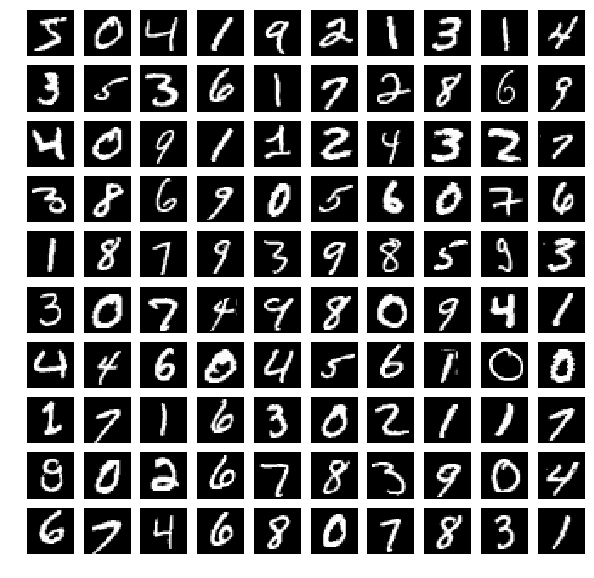

In [8]:
plt.figure(figsize=[10,10])
for i in range(0,100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(x_train[i], (28,28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [9]:
## Set datatypes
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

## Flatten data
x_train = flatten_array(x_train)
x_test = flatten_array(x_test)

print('New train size: ', x_train.shape, ' New test size: ', x_test.shape)

New train size:  (60000, 784)  New test size:  (10000, 784)


# Partition Data

In [11]:
# use readable variable names for test data
test_data, test_labels = x_test, y_test

# partition data based on the train_proportion parameter
if PARAMETERS.train_proportion == 1.0:
   train_data, train_labels, val_data, val_labels = x_train, y_train, x_test, y_test   
else:
   train_data, train_labels, val_data, val_labels = partition_train_val(x_train, y_train, PARAMETERS.train_proportion, PARAMETERS.num_classes) 

# print partitioned dataset sizes
print("Train size: %dx%d" % (train_data.shape[0], train_data.shape[1]))
if PARAMETERS.train_proportion < 1.0:
   print("Validation size: %dx%d" % (val_data.shape[0], val_data.shape[1]))
print("Test size: %dx%d" % (test_data.shape[0], test_data.shape[1]))


Train size: 60000x784
Test size: 10000x784


# Train Model

In [12]:
tf.reset_default_graph()
if PARAMETERS.seed > -1:
  tf.set_random_seed(PARAMETERS.seed)

In [13]:
# Model Initialization
gmvae = GMVAE(PARAMETERS)

In [14]:
# Training Phase
history_loss = gmvae.train(train_data, train_labels, val_data, val_labels)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




Training phase...
(Epoch 1 / 100) Train Loss: 179.51131; Val Loss: 149.40036   Train ACC: 0.39507; Val ACC: 0.55620   Train NMI: 0.22644; Val NMI: 0.49638
(Epoch 2 / 100) Train Loss: 142.43278; Val Loss: 135.96725   Train ACC: 0.55692; Val ACC: 0.57370   Train NMI: 0.48537; Val NMI: 0.52066
(Epoch 3 / 100) Train Loss: 133.42799; Val Loss: 130.38125   Train ACC: 0.57984; Val ACC: 0.59040   Train NMI: 0.51785; Val NMI: 0.53958
(Epoch 4 / 100) Train Loss: 129.13458; Val Loss: 126.90416   Train ACC: 0.58212; Val ACC: 0.58460   Train NMI: 0.53014; Val NMI: 0.56407
(Epoch 5 / 100) Train Loss: 126.52682; Val Loss: 125.23440   Train ACC: 0.59035; Val ACC: 0.58410   Train NMI: 0.55177; Val NMI: 0.56534
(Epoch 6 / 100) Train Loss: 124.71421; Val Loss: 123.80476   Train ACC: 0.60128; Val ACC: 0.58920   Train NMI: 0.56890; Val NMI: 0.58566
(Epoch 7 / 100) Train Loss: 123.48809; Val Loss: 122.88161   Train ACC: 0.60936; Val ACC: 0.61520   Train NMI: 0.57983; Val NMI: 0.61461
(Epoch 8 / 100) Train L

(Epoch 57 / 100) Train Loss: 115.88522; Val Loss: 118.62511   Train ACC: 0.70447; Val ACC: 0.70490   Train NMI: 0.71887; Val NMI: 0.72501
(Epoch 58 / 100) Train Loss: 115.86991; Val Loss: 118.26244   Train ACC: 0.70457; Val ACC: 0.70710   Train NMI: 0.71993; Val NMI: 0.72340
(Epoch 59 / 100) Train Loss: 115.79929; Val Loss: 118.16180   Train ACC: 0.70982; Val ACC: 0.71720   Train NMI: 0.72784; Val NMI: 0.73416
(Epoch 60 / 100) Train Loss: 115.83869; Val Loss: 118.76103   Train ACC: 0.71014; Val ACC: 0.71260   Train NMI: 0.72558; Val NMI: 0.72603
(Epoch 61 / 100) Train Loss: 115.76369; Val Loss: 118.46909   Train ACC: 0.71044; Val ACC: 0.71210   Train NMI: 0.72646; Val NMI: 0.74382
(Epoch 62 / 100) Train Loss: 115.70687; Val Loss: 118.32674   Train ACC: 0.70861; Val ACC: 0.71380   Train NMI: 0.72584; Val NMI: 0.73374
(Epoch 63 / 100) Train Loss: 115.63373; Val Loss: 118.39115   Train ACC: 0.70879; Val ACC: 0.71680   Train NMI: 0.72874; Val NMI: 0.73173
(Epoch 64 / 100) Train Loss: 115.6

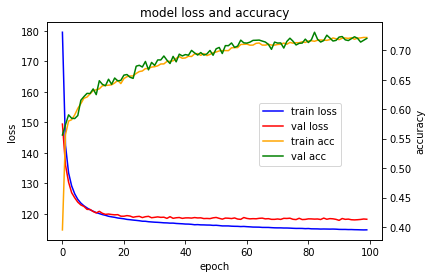

In [49]:
# define loss history potting function
def plothistory(history):
    fig, ax = plt.subplots()
    
    ax.plot(history['train_history_loss'], color='blue')
    ax.plot(history['val_history_loss'], color='red')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    
    ax2=ax.twinx()
    ax2.plot(history['train_history_acc'], color='orange')
    ax2.plot(history['val_history_acc'], color='green')    
    ax2.set_ylabel('accuracy')
    
    plt.title(f'model loss and accuracy')    
    fig.legend(['train loss', 'val loss','train acc', 'val acc'], loc='right', bbox_to_anchor=(0.8, 0.5))
    plt.show()
    plt.savefig('losshist.png')

# plot loss history
plothistory(history_loss)


# Test Data

In [15]:
accuracy, nmi = gmvae.test(test_data, test_labels, 200)

print("Testing phase...")
print("Accuracy: %.5lf,  NMI: %.5lf" % (accuracy, nmi) )

Testing phase...
Accuracy: 0.72010,  NMI: 0.75015


# Image Reconstruction

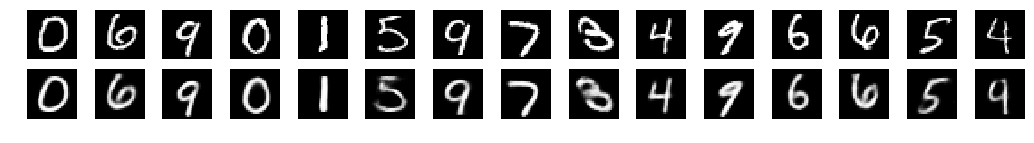

In [16]:
def display_reconstructed(original, reconstructed, n=10):
  plt.figure(figsize=[18,2])
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    if reconstructed is not None:
      plt.subplot(2, n, i + n + 1)
      plt.imshow(reconstructed[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

test_batch_data = test_data[10:30]
reconstructed = gmvae.reconstruct_data(test_batch_data)  
display_reconstructed(test_batch_data, reconstructed, 15)

# Random Generation per Category

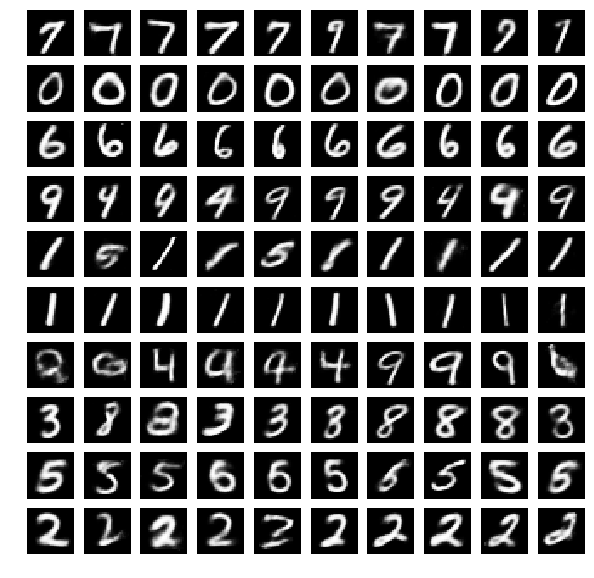

In [17]:
def display_random_generation(generated, num_classes, n=10):
  plt.figure(figsize=[10,10])
  for c in range(num_classes):
    for i in range(n):
      plt.subplot(num_classes, n, (c * n) + i + 1)
      plt.imshow(generated[(c * n) + i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

elem_per_category = 10
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, PARAMETERS.num_classes, elem_per_category)

# Visualization of the feature latent space

In [18]:
# get feature representations
test_features = gmvae.latent_features(test_data, 200)

In [19]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm
tsne_features = TSNE(n_components=2).fit_transform(test_features[:1000,])

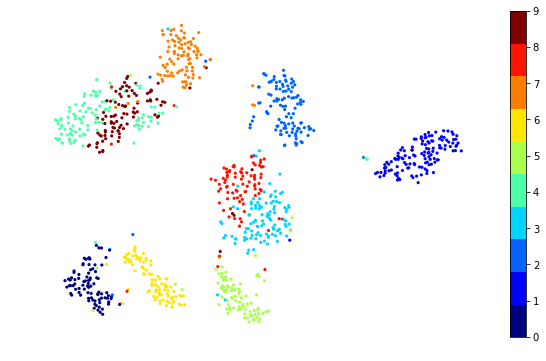

In [20]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('off')
plt.colorbar()